In [8]:
import pandas as pd
import statistics
from sys import argv
import matplotlib.pyplot as plt
import numpy as np
import json

In [9]:
### Get durations in between consecutive timestamps rather than the 
def diff_list(l):
    dl = []
    prev = l[0]
    for item in l[1:]:
        dl.append(item-prev)
        prev = item
    return dl

In [10]:
def cumulative_sum(l):
    sl = []
    sum_ = 0
    for duration in l:
        sum_ += duration
        sl.append(sum_)
    return sl

In [11]:
def filter_for_outliers(unfiltered, **kwargs):
    allowed_kws = {"lt", "gt", "ge", "le", "eq"}
    kws_provided = set(kwargs.keys())
    diff = kws_provided - allowed_kws
    if diff:
        raise ValueError(f"Invalid keyword(s) provided: {diff}")
    filtered = []
    outliers = []
    for val in unfiltered:
        append_val = True
        if "lt" in kws_provided:
            append_val &= (val < kwargs["lt"])
        if "gt" in kws_provided:
            append_val &= (val > kwargs["gt"])
        if "ge" in kws_provided:
            append_val &= (val >= kwargs["ge"])
        if "le" in kws_provided:
            append_val &= (val <= kwargs["le"])
        if "eq" in kws_provided:
            append_val &= (val == kwargs["eq"])
        if append_val: filtered.append(val)
        else: outliers.append(val)
    return filtered, outliers

In [37]:
hostname='192.168.4.29'
df = pd.read_csv('/home/alejandro/Documents/Projects/jRAPL/tests/jmh/msr-update-rate/results/samples-collected_'+hostname+'.csv')
df = df.loc[:, (df != 0).any(axis=0)]
print('read the csv')
header = list(df.head())
del header[-1] # remove timestamp
timestamps = df['timestamp']
print(header)
print(len(df),'total samples')

read the csv
['dram_socket1', 'gpu_socket1', 'core_socket1', 'pkg_socket1']
7780873 total samples


In [67]:
result_dfs = dict()

cutoff = 2000

for powerDomain in header:
    energies = df[powerDomain]
    lastDifferent = energies[0]
    change_ts = [ timestamps[0] ] # timestamps where there was an energy update
    ener_diffs = [] # differences between consecutive non-equal readings
    bw = 0
    for i in range(len(energies)):
        if energies[i] != lastDifferent:
            ener_diffs.append(energies[i] - lastDifferent)
            change_ts.append(timestamps[i])
            lastDifferent = energies[i]
            bw = 0
        else:
            bw += 1
    # Get the difference between consecutive timestamps
    ts_diffs = diff_list(change_ts)
    
    # Get the cumulative sum of the unfiltered duractions
    # Get the filtered durations <=3000 and outliers >3000
    filtered, outliers = filter_for_outliers(ts_diffs, le=cutoff)
    
    result = filtered
    
    result_dfs[powerDomain] = {
                               "change_timestamps": np.array(change_ts),
                               #"reading_change_num": np.array(non_zero_reading_nums),
                               "energy_differences": np.array(ener_diffs),
                               "filtered": np.array(filtered, dtype=np.double),
                               "outliers": np.array(outliers)
                              }  
    
    print(f'collected result dataframe for {powerDomain}; len(outliers)={len(outliers)},len(result)={len(result)}')
    
print('all results stored in \'result_dfs\', currently a dictionary')

collected result dataframe for dram_socket1; len(outliers)=42877,len(result)=16332
collected result dataframe for gpu_socket1; len(outliers)=930,len(result)=6508
collected result dataframe for core_socket1; len(outliers)=66,len(result)=702211
collected result dataframe for pkg_socket1; len(outliers)=66,len(result)=149254
all results stored in 'result_dfs', currently a dictionary


In [68]:
result_dfs.keys()

dict_keys(['dram_socket1', 'gpu_socket1', 'core_socket1', 'pkg_socket1'])

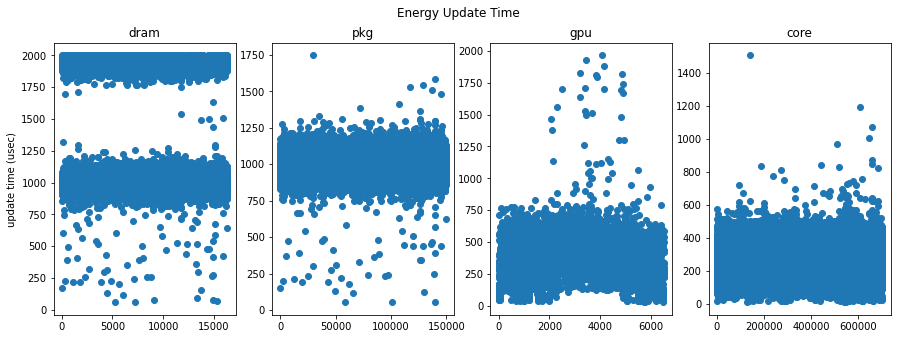

In [69]:
# we're just picking it out of socket1 for what to display in the research paper
s = 1
dram = result_dfs['dram_socket'+str(s)]
pkg = result_dfs['pkg_socket'+str(s)]
core = result_dfs['core_socket'+str(s)]
gpu = result_dfs['gpu_socket'+str(s)]


fig, axs = plt.subplots(1,4,figsize=(15,5))

axs[0].scatter(range(len(dram['filtered'])),dram['filtered'])
axs[0].set_title('dram')
axs[0].set_ylabel('update time (usec)')


axs[1].scatter(range(len(pkg['filtered'])),pkg['filtered'])
axs[1].set_title('pkg')

axs[2].scatter(range(len(gpu['filtered'])),gpu['filtered'])
axs[2].set_title('gpu')

axs[3].scatter(range(len(core['filtered'])),core['filtered'])
axs[3].set_title('core')

fig.suptitle('Energy Update Time')
fig.align_ylabels(axs)

plt.show()
#fig.savefig('energy-update-time-simple_systemB')

In [35]:
# percent that were outliers (above 3000 ms)
nfiltered = len(result_dfs['dram_socket1']['filtered']) + len(result_dfs['pkg_socket1']['filtered'])
nexcluded = len(result_dfs['dram_socket1']['outliers']) + len(result_dfs['pkg_socket1']['outliers'])
print(str(nexcluded/nfiltered * 100) + "% excluded")

0.021643411272159133% excluded
295766 total collected


In [23]:
dram_mean = statistics.mean(dram['filtered'])
dram_stdev = statistics.mean(dram['filtered'])

pkg_mean = statistics.mean(pkg['filtered'])
pkg_stdev = statistics.stdev(pkg['filtered'])

both = list(dram['filtered'])
both.extend(list(pkg['filtered']))
both_mean = statistics.mean(both)
both_stdev = statistics.stdev(both)

print("Mean and stdev:")
print(json.dumps({ 'dram_mean':dram_mean, 'dram_stdev':dram_stdev, 'pkg_mean':pkg_mean, 'pkg_stdev':pkg_stdev,
'both_mean':both_mean, 'both_stdev':both_stdev},indent=2))

Mean and stdev:
{
  "dram_mean": 1011.9549852955128,
  "dram_stdev": 1011.9549852955128,
  "pkg_mean": 1007.83457043375,
  "pkg_stdev": 84.0930127550168,
  "both_mean": 1009.8904452784258,
  "both_stdev": 96.08294846223097
}


In [18]:
#for key in result_dfs.keys():
#    try:
#        plot = results_dfs[key]['filtered'].plot()
#        plot.set_title(f'time to update the MSR for {key.upper()}')
#        plot.get_figure().savefig(f'{key}_msr-update-time.png')
#        # plot.get_figure().clf()
#        with open(key+'_summary-statistics.tex','w') as fh: fh.write(results_dfs[key].describe().to_latex())
#    except:
#        print(f"error plotting results_dfs[{key}]")